# Creating a Panel Dataset of the Indonesian EBATANAS School Test Scores

This notebook consolidates and cleans the EBATANAS test scores from the IFLS community surveys. These community surveys randomly picked a primary, lower secondary, and upper secondary school in the Kabupatens within the provinces that IFLS sampled. Within these schools upto 25 student test scores were randomly selected. It is presumed that the IFLS-East followed the same structure. However, since this survey took place in 2012 the school tests were no longer EBTANAS, rather the UANs tests. The difference: EBTANAS were tests administered at the province level, while UANs were and are still tests administered at the national level. As Indonesia transitioned from EBTANAS to UANs in 2001, the 1993, 1997 and 2000 waves will be EBTANAS. Waves 2007, 2014, and IFLS-East(2012) will contain UAN test scores. 

Z scores at the provincial levels can be constructed to standardize and compare distributions between the school types at the province-year level. We can compare the type of school within a province over time to see if distributions are stationary. If they are, we can average them together to help create an index of school quality for primary, lower secondary, and upper secondary schools as the data permits.

This will be accomplished as follows:

* The two tests that are provided are: Language and Math. These scores are added together with no weighting (as I do not presuppose to know how EBTANAS aggregate tests into a score). I use these raw scores directly.
* We collapse the data of the test scores of all students within a province and school type at the wave year to obtain the provincial averages and standard deviations
* We then construct the Z scores by merging back these values. The distribution of these Z scores can then be compared for each school type over time to guage whether the distributions are stationary (we could use a statistical test for this
* If they are stationary, then we can remove the time dimension and consider the full dataset of student test scores to help create an index of school quality, perhaps along with other statistics of the school that are likewise available for the community surveys

Once the data is cleaned, I will run the following checks to make sure an index can be constructed:

* At the Province-School Type level, are the distributions different across wave years? 
* Are there systematic differences between UANs and EBATANAS distributions (recalling that the test passed from a provincial to a national test in 2003)?

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from string import ascii_lowercase as letters
import seaborn

## File names to access the raw data

In [2]:
Folder = ( "/Users/idiosyncrasy58/Dropbox/Documents/College/"+
           "Universitat Autonoma de Barcelona/IDEA - Economics/"+
           "Doctoral Thesis Ideas/Migration/IFLS/Original Data/" )

Wave_1 = "Wave 1/cf93dta/"
Wave_2 = "Wave 2/cf97dta/"
Wave_3 = "Wave 3/cf00_all_dta/"
Wave_4 = "Wave 4/cf07_all_dta/"
Wave_5 = "Wave 5/cf14_all_dta/"
Wave_East = "IFLSEast/iflse12_all data/community data/"

#1993 Information
Tests_1993_Prime = "bukse02.dta"
Tests_1993_JRH = "bkspe02.dta"
Tests_1993_SRH = "bksae02.dta"
Comm_W_1993 = "commwt.dta"
Fac_W_1993 = "facwgt.dta"

#1997 information
Tests_1997_Prime = "sd.dta"
Tests_1997_JRH = "smp.dta"
Tests_1997_SRH = "smu.dta"

#2000,2007,2014 Information
Tests_2000_2014 = "schl.dta"
Tests_2007 = "schl_f.dta"
School_Type_07 = "schl.dta"
School_Type_14 = "schc_cov.dta"

#IFLS East
Tests_East = "SEK_F2.dta"
School_Type_East = "SEK_COV.dta"

In [3]:
#ASCII Letters for 1993 score names
letter = letters[0:len(letters)-1]

#Function for collapsing Data
function = {'Mean':'mean','SD':'std'}

#Group all schools together (whether private or otherwise) into the same levels
#1.0 = Primary, 2.0 = Lower-Secondary, 3.0 = Upper-Secondary
#For IFLS East, regroup Provinces to their 1993 admin codes
replace_dict = {'School_Type':{2:1,4:3,6:5,7:5,8:5},'Prov Code':{82:81,94:91,92:91,36:32,21:14,75:71,19:16,74:73,76:73}}

## 1993 Wave

In [4]:
#Columns to keep and rename
scores_1 = ['je5'+let+'2' for let in letter]
scores_2 = ['ke5'+let+'2' for let in letter]
scores_3 = ['le5'+let+'2' for let in letter]

col_keep = ['fcode','faccode','commid93']

col_rename_1 = {old:str(letter.index(let)+1) for old in scores_1 for let in letter if let==old[3]}
col_rename_2 = {old:str(letter.index(let)+1) for old in scores_2 for let in letter if let==old[3]}
col_rename_3 = {old:str(letter.index(let)+1) for old in scores_3 for let in letter if let==old[3]}

col_rename = {'faccode':'fascode','commid93':'commid'}

In [5]:
#Read in the STATA .dta as a dataframe
PS_1993 = ( pd.read_stata(Folder+Wave_1+Tests_1993_Prime, columns=col_keep+scores_1)
              .rename(columns = dict(list(col_rename_1.items()) + list(col_rename.items()))) )

JS_1993 = ( pd.read_stata(Folder+Wave_1+Tests_1993_JRH, columns=col_keep+scores_2)
              .rename(columns = dict(list(col_rename_2.items()) + list(col_rename.items()))) )

SS_1993 = ( pd.read_stata(Folder+Wave_1+Tests_1993_SRH, columns=col_keep+scores_3)
              .rename(columns = dict(list(col_rename_3.items()) + list(col_rename.items()))) )

In [6]:
#Create a School_Type variable
PS_1993["School_Type"]=1.0
JS_1993["School_Type"]=3.0
SS_1993["School_Type"]=5.0

#Append all the School Information into one dataframe
Sch_1993 = PS_1993.append(JS_1993,ignore_index=True).append(SS_1993,ignore_index=True)

del (PS_1993,JS_1993,SS_1993)

In [7]:
#Collapse by 'fcode' and 'School_Type' (the two test scores are in sperate rows)
Sch_1993 = Sch_1993.groupby(['fcode','fascode','commid','School_Type'], as_index=False).sum()

In [8]:
#Melt the data (reshape long)
Sch_1993 = ( pd.melt(Sch_1993, id_vars=['fcode','fascode','commid','School_Type'], 
                     value_vars=list(col_rename_1.values()),
                     var_name='Student', value_name='Scores')
               .dropna()
               .sort_values(['fascode','commid','School_Type','Student'])
               )

In [9]:
#Scores can not be larger than 20 by construction of the test, drop inconsistent tests
Sch_1993 = Sch_1993[Sch_1993.Scores<=20]

In [10]:
#Create the Province Column
Sch_1993['Prov Code'] = ( (Sch_1993.commid.astype('int')/100)
                          .astype(str)
                          .str.extract('(\d*)\.',expand=False)
                          .astype('int8') 
                          .replace(replace_dict, inplace=False))

In [11]:
#Collapse the data for student scores by province and get the mean and standard dev
Sch_1993_Prov = ( Sch_1993.drop(['fcode','fascode','commid'], axis=1, inplace=False)
                          .groupby(['Prov Code','School_Type'], as_index=False)['Scores']
                          .agg(function) )

In [12]:
#Merge in the information of provincial averages
Sch_1993 = Sch_1993.merge(Sch_1993_Prov, how='left', 
                          on=['Prov Code','School_Type'])
del Sch_1993_Prov

In [13]:
#Standardize student scores
Sch_1993['Z_Score'] = (Sch_1993['Scores'] - Sch_1993['Mean'])/Sch_1993.SD
Sch_1993.drop(['Mean','SD','Student'], axis=1, inplace=True)

In [14]:
Sch_1993['Year'] = 1993

Plot all the students' Z scores in matplotlib by province and school type

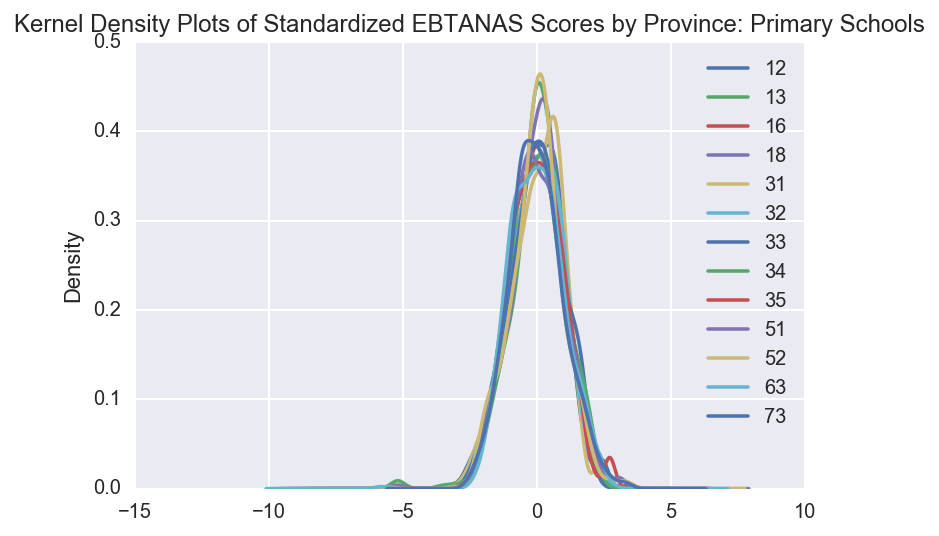

In [15]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
( Sch_1993[Sch_1993.School_Type==1]
          .groupby(["Prov Code"], as_index=False)
          .Z_Score
          .plot(kind='density',
                title='Kernel Density Plots of Standardized EBTANAS Scores by Province: Primary Schools',
                legend=True) );

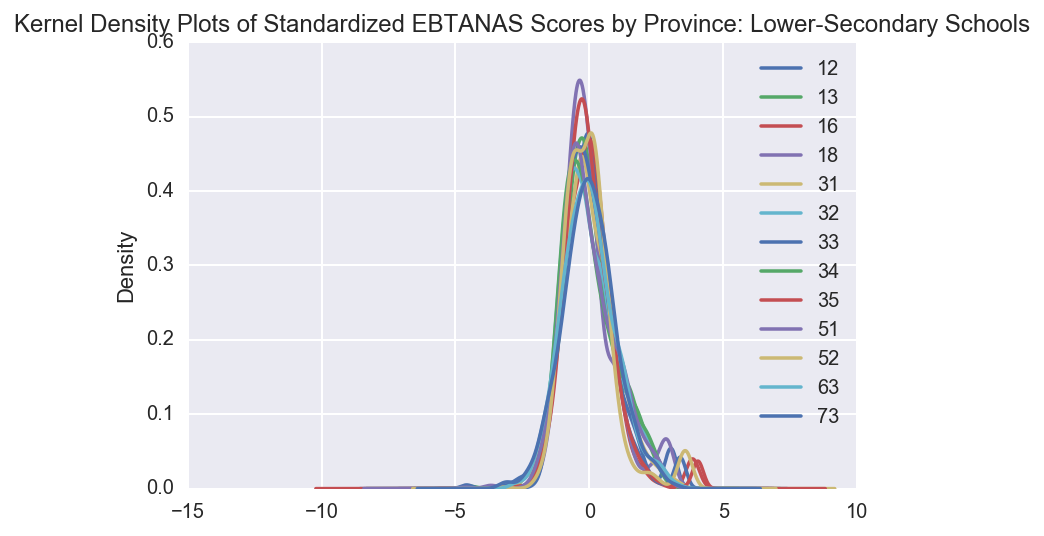

In [16]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
( Sch_1993[Sch_1993.School_Type==3]
          .groupby(["Prov Code"], as_index=False)
          .Z_Score
          .plot(kind='density',
                title='Kernel Density Plots of Standardized EBTANAS Scores by Province: Lower-Secondary Schools',
                legend=True) );

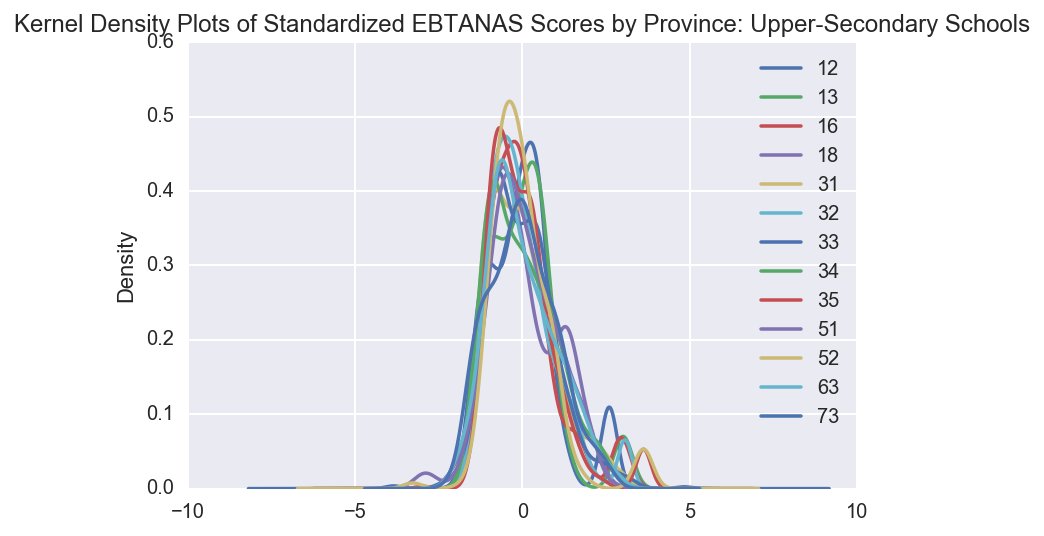

In [17]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
( Sch_1993[Sch_1993.School_Type==5]
          .groupby(["Prov Code"], as_index=False)
          .Z_Score
          .plot(kind='density',
                title='Kernel Density Plots of Standardized EBTANAS Scores by Province: Upper-Secondary Schools',
                legend=True) );

## 1997 Wave

In [18]:
#Columns to keep and rename
scores = ['score'+let+str(num) for let in 'ab' for num in range(1,26)]
col_keep = ['fcode'] + scores

In [19]:
#Read in the STATA .dta as a dataframe

PS_1997 = pd.read_stata(Folder+Wave_2+Tests_1997_Prime, columns=col_keep)
JS_1997 = pd.read_stata(Folder+Wave_2+Tests_1997_JRH, columns=col_keep)
SS_1997 = pd.read_stata(Folder+Wave_2+Tests_1997_SRH, columns=col_keep)

In [20]:
#Create a School_Type variable
PS_1997["School_Type"]=1.0
JS_1997["School_Type"]=3.0
SS_1997["School_Type"]=5.0

#Append all the School Information into one dataframe
Sch_1997 = PS_1997.append(JS_1997,ignore_index=True).append(SS_1997,ignore_index=True)

del (PS_1997,JS_1997,SS_1997)

In [21]:
#Melt the data (reshape long)
Sch_1997 = ( pd.melt(Sch_1997,id_vars=['fcode','School_Type'], value_vars=scores,
                     var_name='Student', value_name='Scores')
               .dropna()
               .sort_values(['fcode','School_Type','Student'])
               )

#Split the Student values into Student Numbers (grab the number from end of string)
Sch_1997["Student"] = ( Sch_1997.Student
                                .str.extract('\D*(\d+)',expand=False)
                                .astype('int8') )

In [22]:
#Collapse the data by fcode and student to sum the scores of Lang and Math tests
Sch_1997 = Sch_1997.groupby(['fcode','School_Type',"Student"], as_index=False).sum()

In [23]:
#Scores can not be larger than 20 by construction of the test, drop inconsistent tests
Sch_1997 = Sch_1997[Sch_1997.Scores<=20]

In [24]:
#Create the Province Column
Sch_1997['Prov Code'] = ( (Sch_1997.fcode.astype('int')/100000)
                          .astype(str)
                          .str.extract('(\d*)\.',expand=False)
                          .astype('int8')
                          .replace(replace_dict, inplace=False))

In [25]:
#Collapse the data for student scores by province and get the mean and standard dev
Sch_1997_Prov = ( Sch_1997.drop(['fcode'], axis=1, inplace=False)
                          .groupby(['Prov Code','School_Type'], as_index=False)['Scores']
                          .agg(function) )

In [26]:
#Merge in the information of provincial averages
Sch_1997 = Sch_1997.merge(Sch_1997_Prov, how='left', 
                          on=['Prov Code','School_Type'])
del Sch_1997_Prov

In [27]:
#Standardize student scores
Sch_1997['Z_Score'] = (Sch_1997['Scores'] - Sch_1997['Mean'])/Sch_1997.SD
Sch_1997.drop(['Mean','SD','Student'], axis=1, inplace=True)

In [28]:
Sch_1997['commid'] = Sch_1997.fcode.str[0:4]
Sch_1997['Year'] = 1997

Plot all the students' Z scores in matplotlib by province and school type

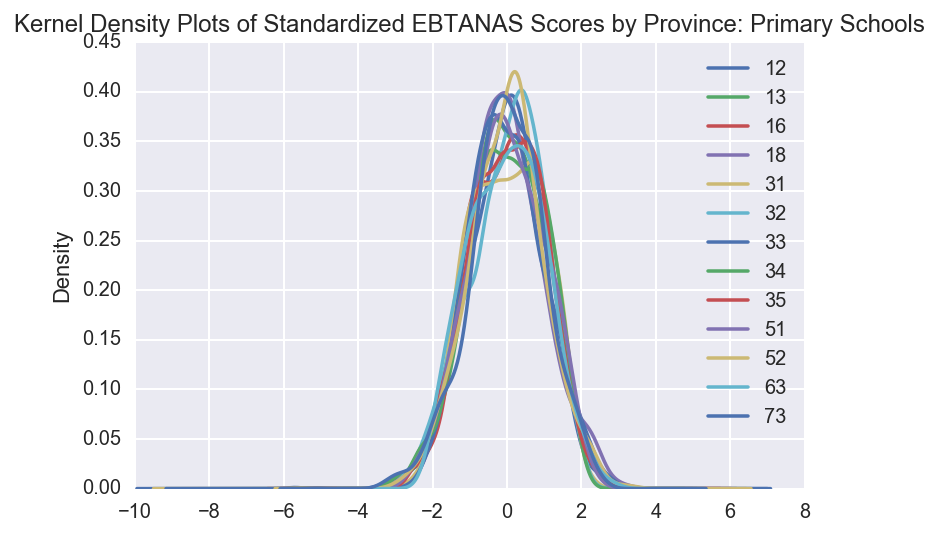

In [29]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
( Sch_1997[Sch_1997.School_Type==1]
          .groupby(["Prov Code"], as_index=False)
          .Z_Score
          .plot(kind='density',
                title='Kernel Density Plots of Standardized EBTANAS Scores by Province: Primary Schools',
                legend=True) );

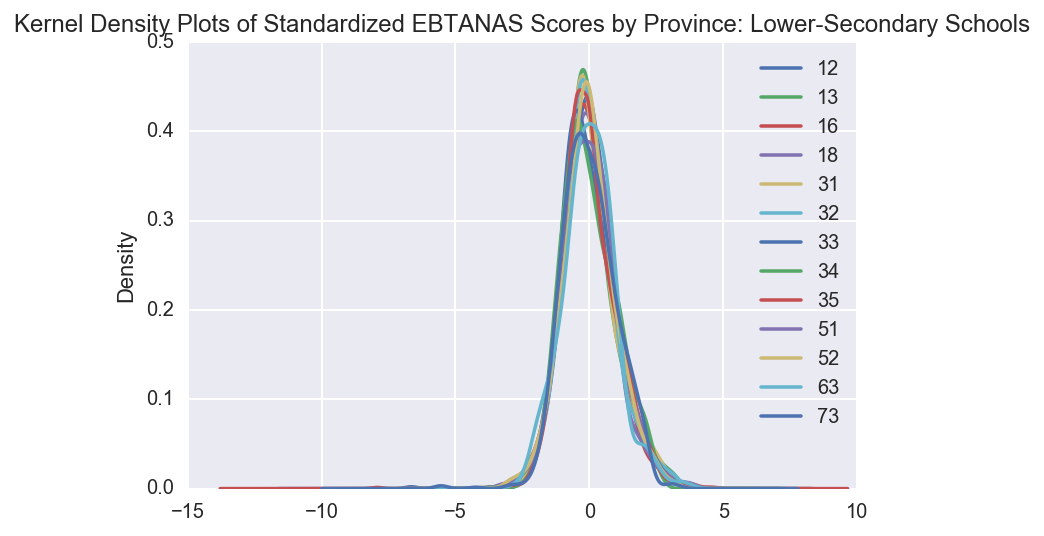

In [30]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
( Sch_1997[Sch_1997.School_Type==3]
          .groupby(["Prov Code"], as_index=False)
          .Z_Score
          .plot(kind='density',
                title='Kernel Density Plots of Standardized EBTANAS Scores by Province: Lower-Secondary Schools',
                legend=True) );

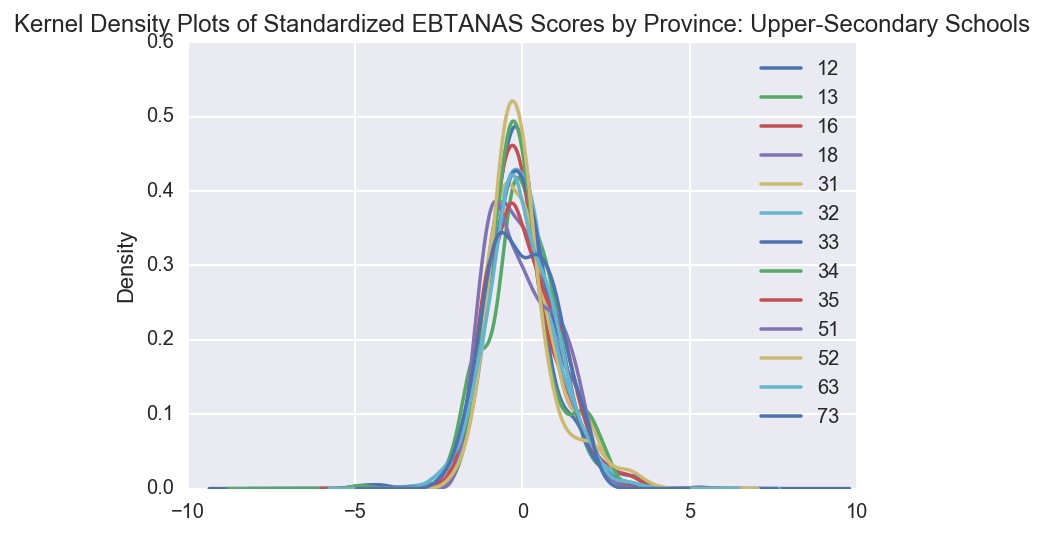

In [31]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
( Sch_1997[Sch_1997.School_Type==5]
          .groupby(["Prov Code"], as_index=False)
          .Z_Score
          .plot(kind='density',
                title='Kernel Density Plots of Standardized EBTANAS Scores by Province: Upper-Secondary Schools',
                legend=True) );

## 2000 Wave

In [32]:
#Adjust the columns to keep
col_keep = ['fcode00','fascode','commid00','cov2'] + scores
col_rename = {'fcode00':'fcode','commid00':'commid','cov2':'School_Type'}

In [33]:
#Read in the STATA .dta as a dataframe
Sch_2000 = ( pd.read_stata(Folder+Wave_3+Tests_2000_2014, columns=col_keep)
               .rename(columns=col_rename) )

In [34]:
#Melt the data (reshape long)
Sch_2000 = ( pd.melt(Sch_2000,id_vars=['fcode','fascode','commid','School_Type'], value_vars=scores,
                     var_name='Student', value_name='Scores')
               .dropna()
               .sort_values(['fascode','commid','School_Type','Student'])
               )

#Split the Student values into Student Numbers (grab the number from end of string)
Sch_2000["Student"] = ( Sch_2000.Student
                                .str.extract('\D*(\d+)',expand=False)
                                .astype('int8') )

In [35]:
#Group all schools together
Sch_2000.replace(replace_dict, inplace=True)

In [36]:
#Collapse the data by fcode and student to sum the scores of Lang and Math tests
Sch_2000 = Sch_2000.groupby(['fcode','fascode','commid','School_Type',"Student"], as_index=False).sum()

In [37]:
#Scores can not be larger than 20 by construction of the test, drop inconsistent tests
Sch_2000 = Sch_2000[Sch_2000.Scores<=20]

In [38]:
#Create the Province Column
Sch_2000['Prov Code'] = ( (Sch_2000.commid.astype('int')/100)
                          .astype(str)
                          .str.extract('(\d*)\.',expand=False)
                          .astype('int8')
                          .replace(replace_dict, inplace=False))

#Drop if province is 99
Sch_2000 = Sch_2000[Sch_2000["Prov Code"]<99]

In [39]:
#Collapse the data for student scores by province and get the mean and standard dev
Sch_2000_Prov = ( Sch_2000.drop(['fascode','commid'], axis=1, inplace=False)
                          .groupby(['Prov Code','School_Type'], as_index=False)['Scores']
                          .agg(function) )

In [40]:
#Merge in the information of provincial averages
Sch_2000 = Sch_2000.merge(Sch_2000_Prov, how='left', 
                          on=['Prov Code','School_Type'])
del Sch_2000_Prov

In [41]:
#Standardize student scores
Sch_2000['Z_Score'] = (Sch_2000['Scores'] - Sch_2000['Mean'])/Sch_2000.SD
Sch_2000.drop(['Mean','SD','Student'], axis=1, inplace=True)

In [42]:
Sch_2000['Year'] = 2000

Plot all the students' Z scores in matplotlib by province and school type

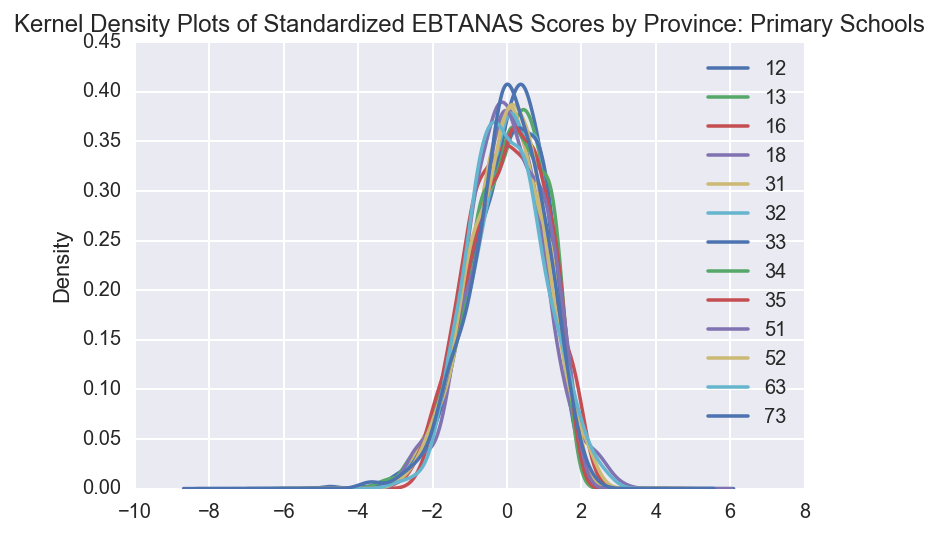

In [43]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
( Sch_2000[Sch_2000.School_Type==1]
          .groupby(["Prov Code"], as_index=False)
          .Z_Score
          .plot(kind='density',
                title='Kernel Density Plots of Standardized EBTANAS Scores by Province: Primary Schools',
                legend=True) );

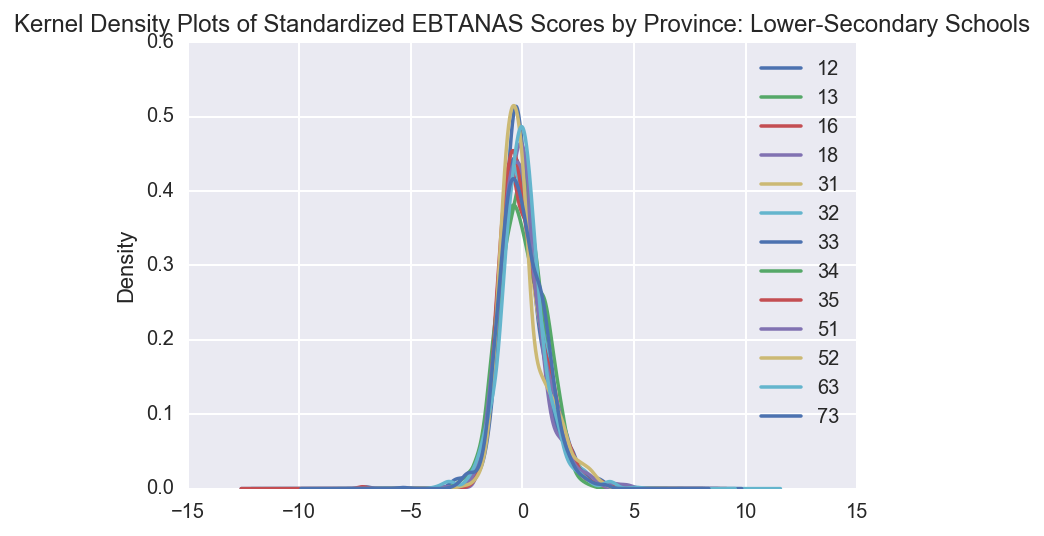

In [44]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
( Sch_2000[Sch_2000.School_Type==3]
          .groupby(["Prov Code"], as_index=False)
          .Z_Score
          .plot(kind='density',
                title='Kernel Density Plots of Standardized EBTANAS Scores by Province: Lower-Secondary Schools',
                legend=True) );

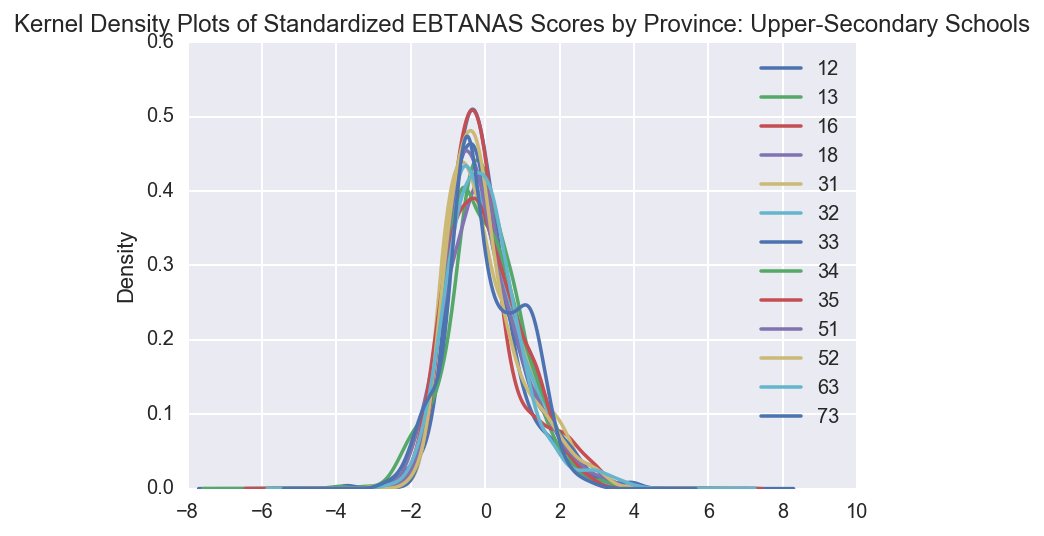

In [45]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
( Sch_2000[Sch_2000.School_Type==5]
          .groupby(["Prov Code"], as_index=False)
          .Z_Score
          .plot(kind='density',
                title='Kernel Density Plots of Standardized EBTANAS Scores by Province: Upper-Secondary Schools',
                legend=True) );

## 2007 Wave

In [46]:
#Adjust the columns to keep
#The below list are the identifiers for facilities in this wave
col_keep_ident = ['fcode07','fascode','commid07']

#The following list are the test scores
col_keep_tests = ['scorea','scoreb']

#The following are the school types from the cover data set
col_keep_schtype = ['cov2']

#Rename Columns
col_rename_1 = {'fcode07':'fcode','commid07':'commid'}
col_rename_2 = {'cov2':'School_Type'}

In [47]:
#Read in the school stata dataset

Sch_2007 =( pd.read_stata(Folder+Wave_4+Tests_2007, columns=col_keep_ident+col_keep_tests)
              .rename(columns=col_rename_1) )

Sch_Type = ( pd.read_stata(Folder+Wave_4+School_Type_07, columns=col_keep_ident+col_keep_schtype)
               .rename(columns=dict(list(col_rename_1.items())+list(col_rename_2.items())))
               .drop_duplicates(subset=['fascode','commid'],keep='first', inplace=False) )

In [48]:
#merge the school types and drop the sch type dataset

Sch_2007 = ( Sch_2007.merge(Sch_Type, how='inner', 
                            on=['fcode','fascode','commid'])
                     .dropna() )

del Sch_Type

In [49]:
#Create the Province Column
Sch_2007['Prov Code'] = ( (Sch_2007.commid.astype('int')/100)
                          .astype(str)
                          .str.extract('(\d*)\.',expand=False)
                          .astype('int8')
                          .replace(replace_dict, inplace=False))

#Drop if province is 99
Sch_2007 = Sch_2007[Sch_2007["Prov Code"]<99]

In [50]:
#Group all schools
Sch_2007.replace(replace_dict, inplace=True)

In [51]:
#Sum the test scores
Sch_2007['Scores'] = (Sch_2007.scorea + Sch_2007.scoreb)
Sch_2007.drop(['scorea','scoreb'], axis=1, inplace=True)

In [52]:
#Drop all values that are above the allowable range of the test (20 points total)
Sch_2007 = Sch_2007[Sch_2007.Scores<=20]

In [53]:
#Collapse the data for student scores by province and get the mean and standard dev
Sch_2007_Prov = ( Sch_2007.drop(['fcode','fascode','commid'], axis=1, inplace=False)
                          .groupby(['Prov Code','School_Type'], as_index=False)['Scores']
                          .agg(function) )

In [54]:
#Merge in the information of provincial averages
Sch_2007 = Sch_2007.merge(Sch_2007_Prov, how='left', 
                          on=['Prov Code','School_Type'])
del Sch_2007_Prov

In [55]:
#Standardize student scores
Sch_2007['Z_Score'] = (Sch_2007['Scores'] - Sch_2007['Mean'])/Sch_2007.SD
Sch_2007.drop(['Mean','SD'], axis=1, inplace=True)

In [56]:
Sch_2007['Year'] = 2007

Plot all the students' Z scores in matplotlib by province and school type

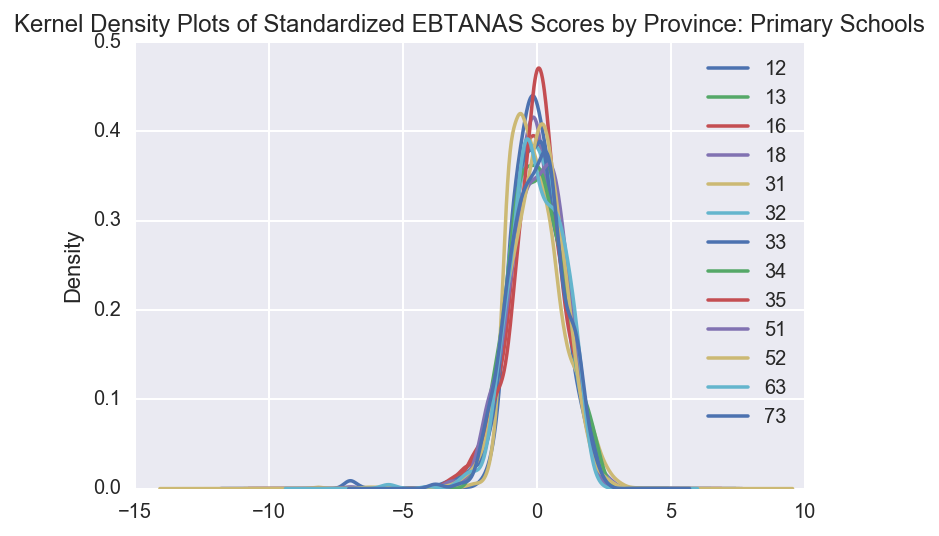

In [57]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
( Sch_2007[Sch_2007.School_Type==1]
          .groupby(["Prov Code"], as_index=False)
          .Z_Score
          .plot(kind='density',
                title='Kernel Density Plots of Standardized EBTANAS Scores by Province: Primary Schools',
                legend=True) );

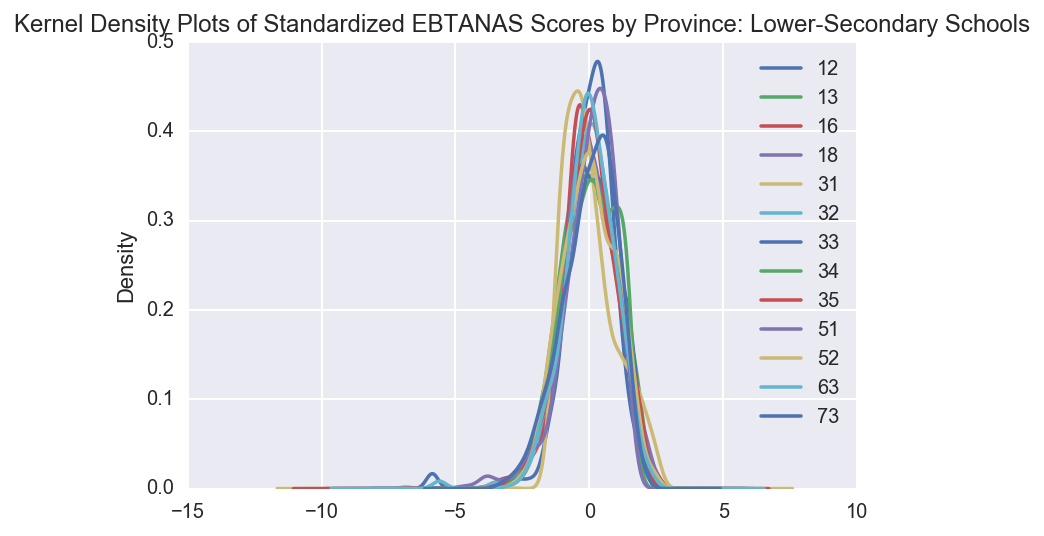

In [58]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
( Sch_2007[Sch_2007.School_Type==3]
          .groupby(["Prov Code"], as_index=False)
          .Z_Score
          .plot(kind='density',
                title='Kernel Density Plots of Standardized EBTANAS Scores by Province: Lower-Secondary Schools',
                legend=True) );

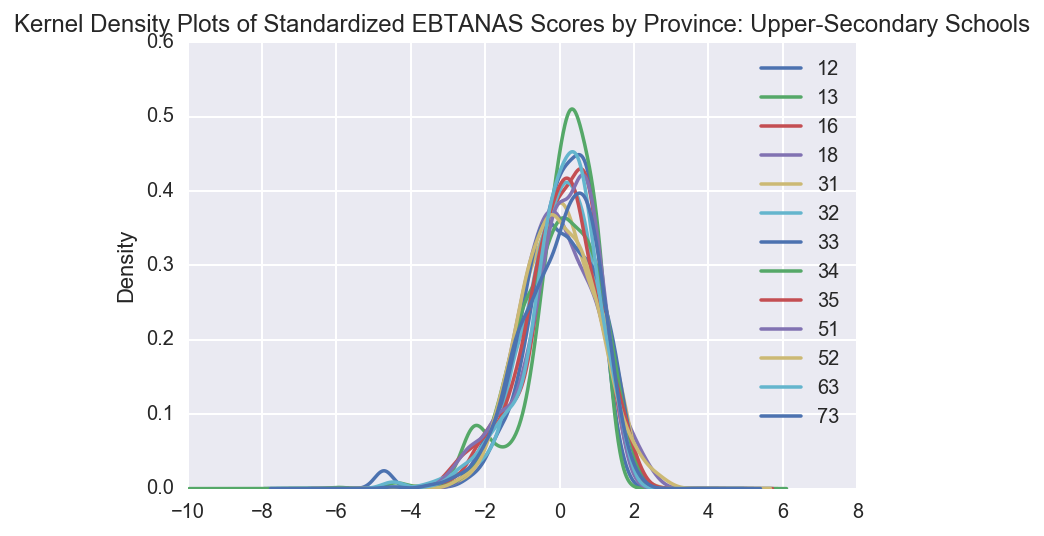

In [59]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
( Sch_2007[Sch_2007.School_Type==5]
          .groupby(["Prov Code"], as_index=False)
          .Z_Score
          .plot(kind='density',
                title='Kernel Density Plots of Standardized EBTANAS Scores by Province: Upper-Secondary Schools',
                legend=True) );

## 2014 Wave

In [60]:
#Adjust the columns to keep
#The below list are the identifiers for facilities in this wave
col_keep_ident = ['fcode14','fascode','commid14','ea']

#The following list are the test scores
col_keep_tests = ['f3a','f3b']

#The following are the school types from the cover data set
col_keep_schtype = ['cov2']

#Rename Columns
col_rename_1 = {'fcode14':'fcode','commid14':'commid','f3a':'score1','f3b':'score2'}
col_rename_2 = {'commid14':'commid','cov2':'School_Type'}

In [61]:
#Read in the school stata dataset

Sch_2014 =( pd.read_stata(Folder+Wave_5+Tests_2000_2014, columns=col_keep_ident+col_keep_tests)
              .rename(columns=col_rename_1) )

Sch_Type = ( pd.read_stata(Folder+Wave_5+School_Type_14, columns=col_keep_ident[1:]+col_keep_schtype)
               .rename(columns=col_rename_2) )

In [62]:
#merge the school types and drop the sch type dataset

Sch_2014 = ( Sch_2014.merge(Sch_Type, how='inner', 
                            on=['fascode','commid','ea'])
                     .drop('ea', axis=1, inplace=False)
                     .dropna() )

del Sch_Type

In [63]:
#Create the Province Column
Sch_2014['Prov Code'] = ( (Sch_2014.commid.astype('int')/100)
                          .astype(str)
                          .str.extract('(\d*)\.',expand=False)
                          .astype('int8')
                          .replace(replace_dict, inplace=False))

In [64]:
#Group all schools together
Sch_2014.replace(replace_dict, inplace=True)

In [65]:
#Sum the test scores
Sch_2014['Scores'] = (Sch_2014.score1/2.5 + Sch_2014.score2/2.5)
Sch_2014.drop(['score1','score2'], axis=1, inplace=True)

In [66]:
#Collapse the data for student scores by province and get the mean and standard dev
Sch_2014_Prov = ( Sch_2014.drop(['fcode','fascode','commid'], axis=1, inplace=False)
                          .groupby(['Prov Code','School_Type'], as_index=False)['Scores']
                          .agg(function) )

In [67]:
#Merge in the information of provincial averages
Sch_2014 = Sch_2014.merge(Sch_2014_Prov, how='left', 
                          on=['Prov Code','School_Type'])
del Sch_2014_Prov

In [68]:
#Standardize student scores
Sch_2014['Z_Score'] = (Sch_2014['Scores'] - Sch_2014['Mean'])/Sch_2014.SD
Sch_2014.drop(['Mean','SD'], axis=1, inplace=True)

In [69]:
Sch_2014['Year'] = 2014

Plot all the students' Z scores in matplotlib by province and school type

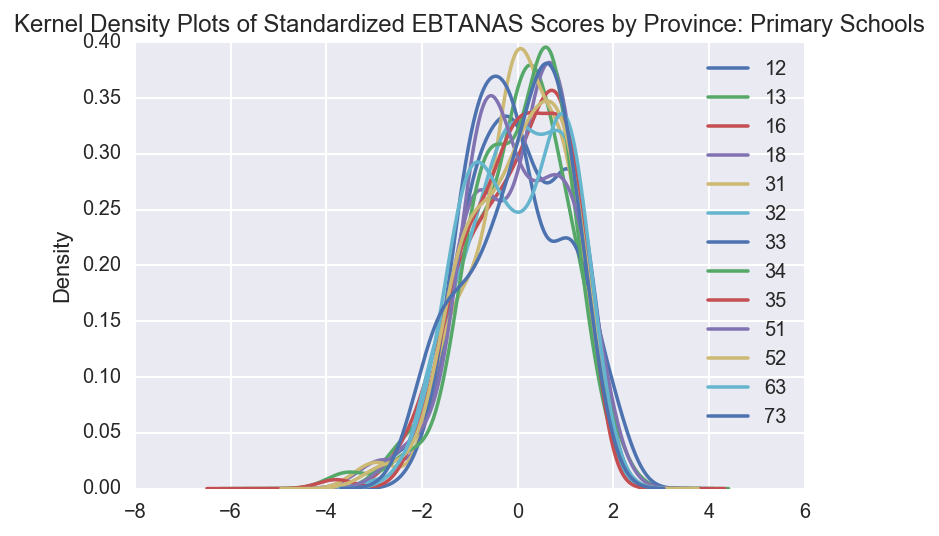

In [70]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
( Sch_2014[Sch_2014.School_Type==1]
          .groupby(["Prov Code"], as_index=False)
          .Z_Score
          .plot(kind='density',
                title='Kernel Density Plots of Standardized EBTANAS Scores by Province: Primary Schools',
                legend=True) );

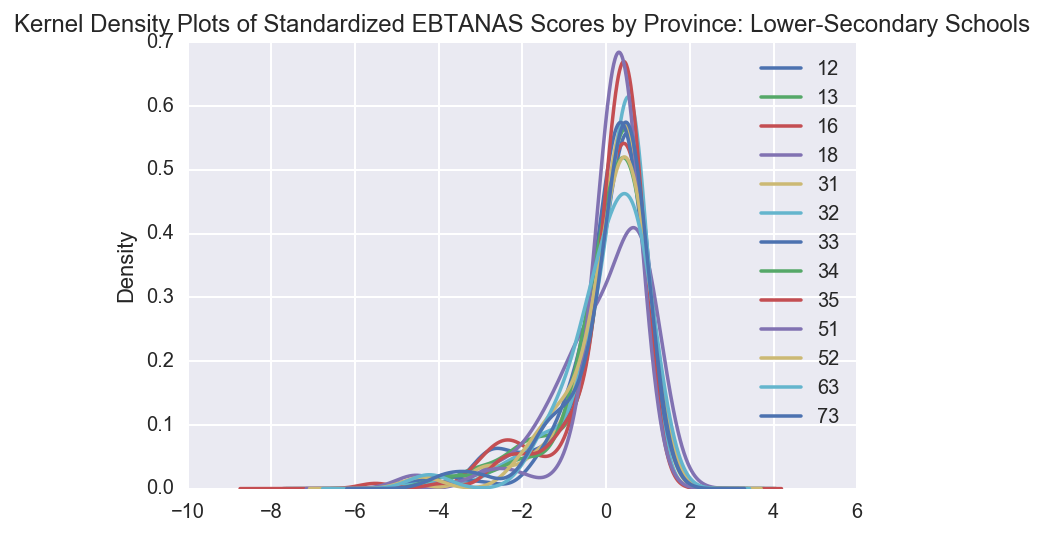

In [71]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
( Sch_2014[Sch_2014.School_Type==3]
          .groupby(["Prov Code"], as_index=False)
          .Z_Score
          .plot(kind='density',
                title='Kernel Density Plots of Standardized EBTANAS Scores by Province: Lower-Secondary Schools',
                legend=True) );

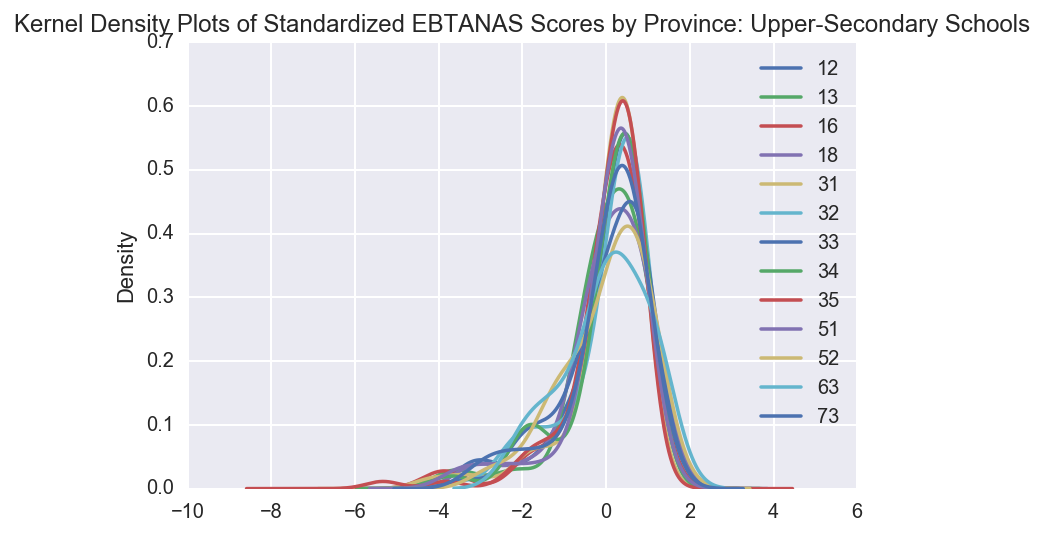

In [72]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
( Sch_2014[Sch_2014.School_Type==5]
          .groupby(["Prov Code"], as_index=False)
          .Z_Score
          .plot(kind='density',
                title='Kernel Density Plots of Standardized EBTANAS Scores by Province: Upper-Secondary Schools',
                legend=True) );

## IFLS-East

In [73]:
#Adjust the columns to keep
#The below list are the identifiers for facilities in this wave
col_keep_ident = ['fcode','commid12']

#The following list are the test scores
col_keep_tests = ['fnilaia','fnilaib']

#The following are the school types from the cover data set
col_keep_schtype = ['cov2','fascode12']

#Rename Columns
col_rename_1 = {'commid12':'commid','fnilaia':'score1','fnilaib':'score2'}
col_rename_2 = {'commid12':'commid','cov2':'School_Type','fascode12':'fascode'}

In [74]:
#Read in the school stata dataset

Sch_East = ( pd.read_stata(Folder+Wave_East+Tests_East, columns=col_keep_ident+col_keep_tests)
               .rename(columns=col_rename_1) )

Sch_Type = ( pd.read_stata(Folder+Wave_East+School_Type_East, 
                           columns=col_keep_ident[1:]+col_keep_schtype, 
                           convert_categoricals=False)
               .rename(columns=col_rename_2) )

In [75]:
#Create the fascode in the test dataset (Sch_East)
Sch_East["fascode"] = Sch_East.commid + Sch_East.fcode.str[3:]

In [76]:
#merge the school types and drop the sch type dataset

Sch_East = ( Sch_East.merge(Sch_Type, how='inner', 
                            on=['fascode','commid'])
                     .dropna() )

del Sch_Type

In [77]:
#Create the Province Column
Sch_East['Prov Code'] = ( (Sch_East.commid.astype('int')/100)
                          .astype(str)
                          .str.extract('(\d*)\.',expand=False)
                          .astype('int8'))
Sch_East.replace(replace_dict, inplace=True)

In [78]:
#Sum the test scores
Sch_East['Scores'] = (Sch_East.score1/100 + Sch_East.score2/100)
Sch_East.drop(['score1','score2'], axis=1, inplace=True)

In [79]:
#Drop all values that are above the allowable range of the test (2000 points total)
Sch_East = Sch_East[Sch_East.Scores<=20]

In [80]:
#Collapse the data for student scores by province and get the mean and standard dev
Sch_East_Prov = ( Sch_East.drop(['fcode','fascode','commid'], axis=1, inplace=False)
                          .groupby(['Prov Code','School_Type'], as_index=False)['Scores']
                          .agg(function) )

In [81]:
#Merge in the information of provincial averages
Sch_East = Sch_East.merge(Sch_East_Prov, how='left', 
                          on=['Prov Code','School_Type'])
del Sch_East_Prov

In [82]:
#Standardize student scores
Sch_East['Z_Score'] = (Sch_East['Scores'] - Sch_East['Mean'])/Sch_East.SD
Sch_East.drop(['Mean','SD'], axis=1, inplace=True)

In [83]:
Sch_East['Year'] = 2012

Plot all the students' Z scores in matplotlib by province and school type

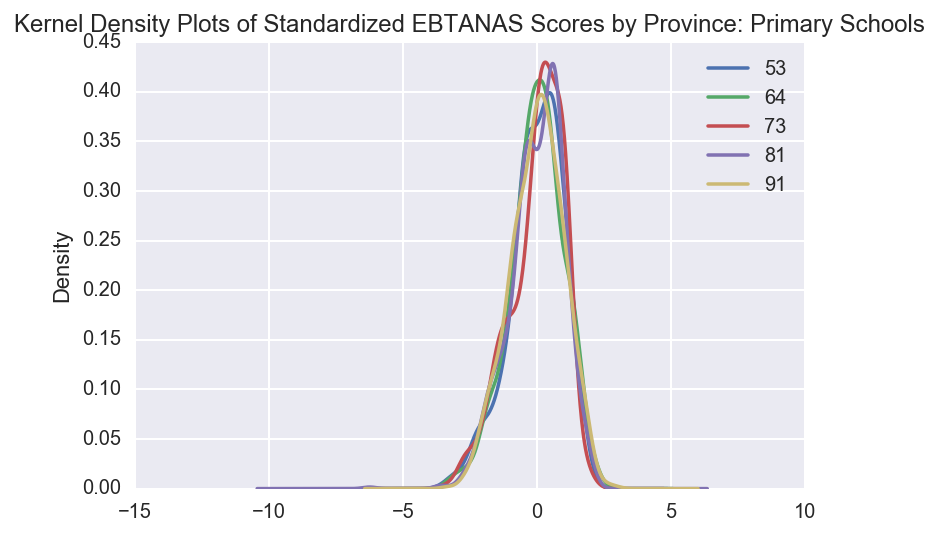

In [84]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
( Sch_East[Sch_East.School_Type==1]
          .groupby(["Prov Code"], as_index=False)
          .Z_Score
          .plot(kind='density',
                title='Kernel Density Plots of Standardized EBTANAS Scores by Province: Primary Schools',
                legend=True) );

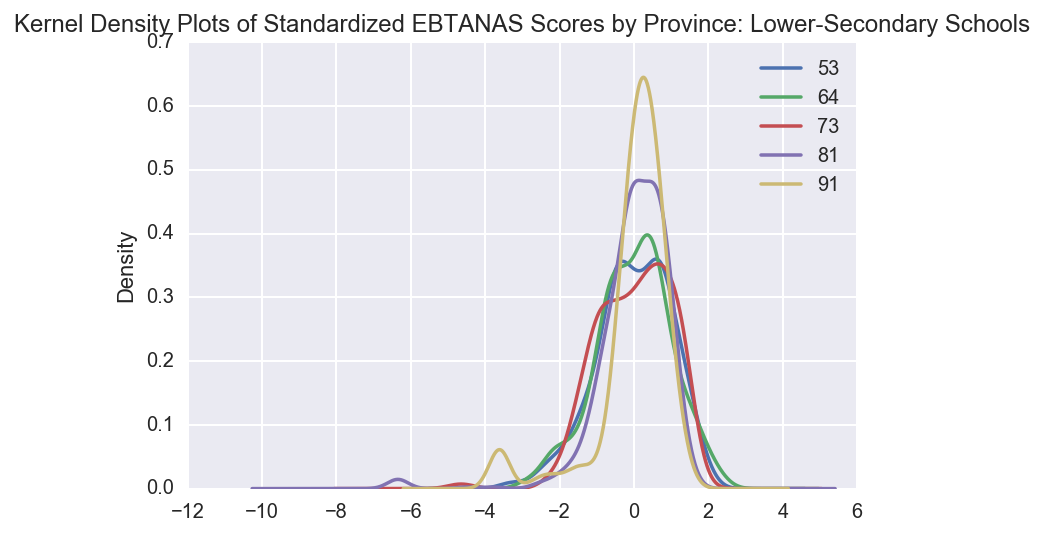

In [85]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
( Sch_East[Sch_East.School_Type==3]
          .groupby(["Prov Code"], as_index=False)
          .Z_Score
          .plot(kind='density',
                title='Kernel Density Plots of Standardized EBTANAS Scores by Province: Lower-Secondary Schools',
                legend=True) );

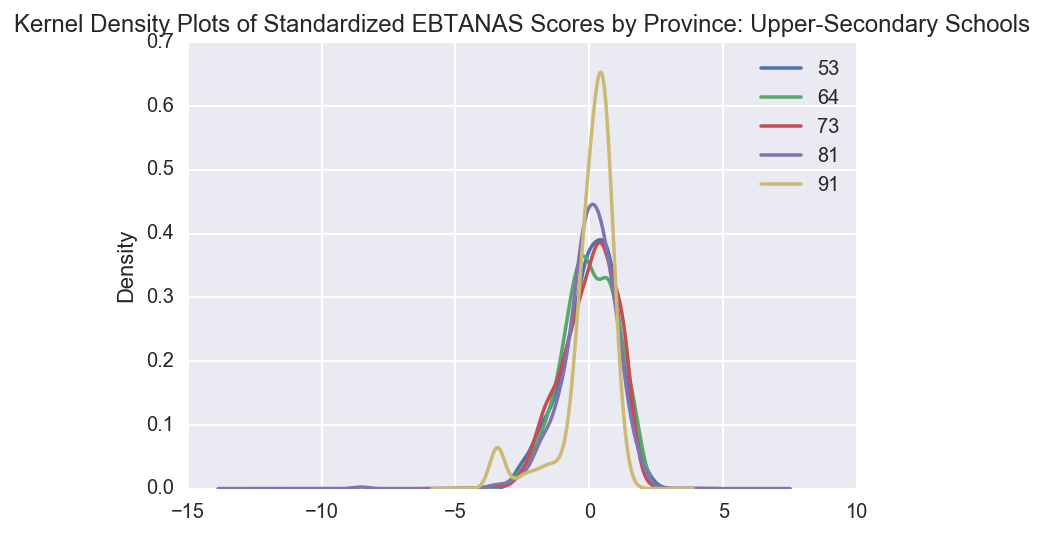

In [86]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
( Sch_East[Sch_East.School_Type==5]
          .groupby(["Prov Code"], as_index=False)
          .Z_Score
          .plot(kind='density',
                title='Kernel Density Plots of Standardized EBTANAS Scores by Province: Upper-Secondary Schools',
                legend=True) );

## Append all waves into one dataframe

In [87]:
Sch_Test_Scores = ( Sch_1993.append(Sch_1997,ignore_index=True)
                            .append(Sch_2000,ignore_index=True)
                            .append(Sch_2007,ignore_index=True)
                            .append(Sch_East,ignore_index=True)
                            .append(Sch_2014,ignore_index=True)
                            .sort_values(['Prov Code','Year','fcode']))

del (Sch_1993, Sch_1997, Sch_2000, Sch_2007, Sch_2014, Sch_East)

## Run Statsistical Tests on the Samples to test if there is stationarity between years for each province at each school level

In [88]:
from scipy.stats import ks_2samp as KS
import itertools

In [89]:
#Create the iterable lists 
prov = Sch_Test_Scores.ix[Sch_Test_Scores.Year!=2012,"Prov Code"].unique().tolist()
school_type = Sch_Test_Scores.School_Type.unique().astype('int').tolist()

#create the year combinations to test (using itertools, create the unique combinations of years)
years = Sch_Test_Scores.ix[Sch_Test_Scores.Year!=2012,"Year"].unique().tolist()
subset = itertools.combinations(years, 2)

In [90]:
Results = []

for i,j in subset:
    for sch in school_type:
        for p in prov:
            pval=0
            Output = (
                KS(
                   Sch_Test_Scores.ix[(Sch_Test_Scores["Prov Code"]==p) & 
                                      (Sch_Test_Scores.School_Type==sch) & 
                                      (Sch_Test_Scores.Year==i),'Z_Score'],
                   Sch_Test_Scores.ix[(Sch_Test_Scores["Prov Code"]==p) & 
                                      (Sch_Test_Scores.School_Type==sch) & 
                                      (Sch_Test_Scores.Year==j),'Z_Score'] 
                  )
            )
            
            if Output[1]>0.05:
                pval=1
            
            Results.append(pval)

In [91]:
#Proportion of tests that are stationary (could not reject the null that the two distributions are the same)
print(sum(Results)/len(Results))
print(len(Results))

0.4461538461538462
390


From the above, only 45% of the 390 tests came back as stationary. So the other 55% of the tests rejected the null that the distributions across two time periods compared at the province-school type level are stationary.

## At the National Level (by Year-School Type)

In [92]:
Sch_Test_Scores = Sch_Test_Scores.merge(
                        Sch_Test_Scores
                            .groupby(["Year","School_Type"], as_index=False)["Scores"]
                            .agg(function),
                        how='left', on=["Year","School_Type"])

In [93]:
Sch_Test_Scores["National Z_Score"] = (Sch_Test_Scores['Scores'] - Sch_Test_Scores['Mean'])/Sch_Test_Scores.SD
Sch_Test_Scores.drop(['Mean','SD'], axis=1, inplace=True)

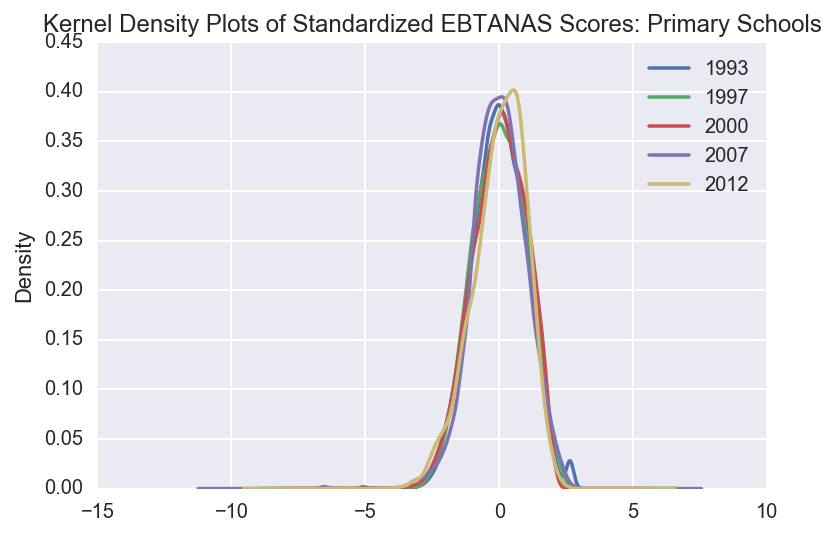

In [94]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
( Sch_Test_Scores[(Sch_Test_Scores.School_Type==1) & (Sch_Test_Scores.Year<2014)]
          .groupby(["Year"], as_index=False)
          ["National Z_Score"]
          .plot(kind='density',
                title='Kernel Density Plots of Standardized EBTANAS Scores: Primary Schools',
                legend=True) );

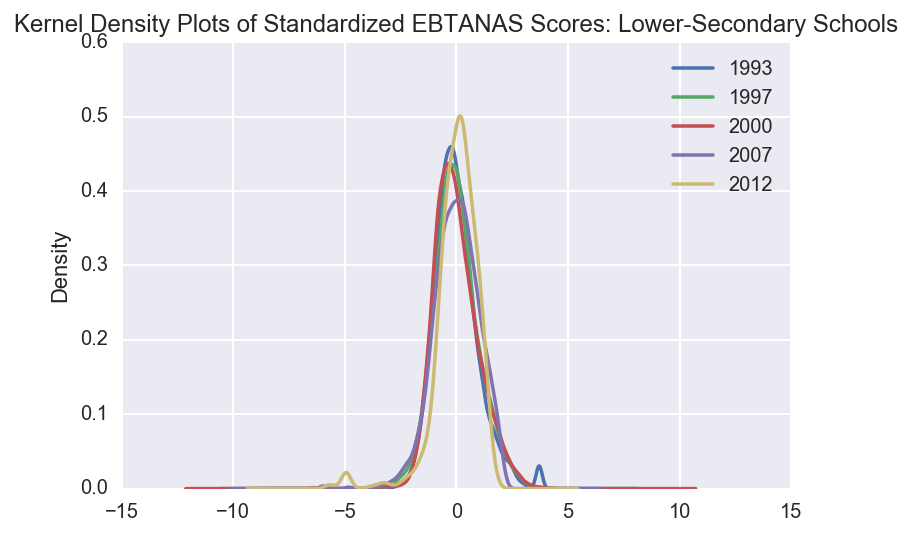

In [95]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
( Sch_Test_Scores[(Sch_Test_Scores.School_Type==3) &( Sch_Test_Scores.Year<2014)]
          .groupby(["Year"], as_index=False)
          ["National Z_Score"]
          .plot(kind='density',
                title='Kernel Density Plots of Standardized EBTANAS Scores: Lower-Secondary Schools',
                legend=True) );

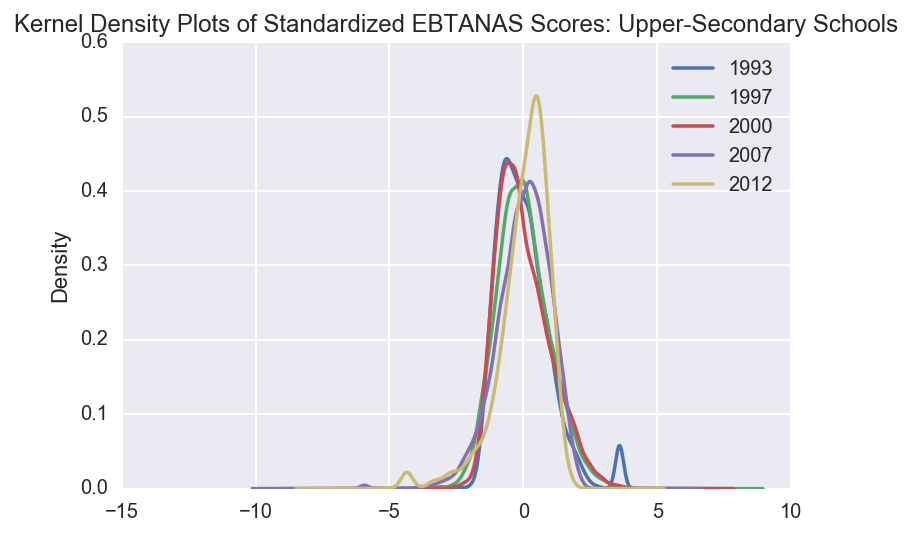

In [96]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
( Sch_Test_Scores[(Sch_Test_Scores.School_Type==5) & (Sch_Test_Scores.Year<2014)]
          .groupby(["Year"], as_index=False)
          ["National Z_Score"]
          .plot(kind='density',
                title='Kernel Density Plots of Standardized EBTANAS Scores: Upper-Secondary Schools',
                legend=True) );

In [97]:
( Sch_Test_Scores.ix[Sch_Test_Scores.Year<2014,["Year","School_Type","Prov Code","National Z_Score"]]
               .groupby(["Year","School_Type","Prov Code"])
               .mean() )

National Z_Score
Year School_Type Prov Code                  
1993 1.0         12                 0.014023
                 13                -0.088307
                 16                -0.326880
                 18                -0.487499
                 31                 0.379815
                 32                 0.311856
                 33                 0.137896
                 34                -0.079435
                 35                -0.164227
                 51                -0.109946
                 52                -0.265961
                 63                -0.238322
                 73                -0.633711
     3.0         12                 0.320736
                 13                 0.102760
                 16                -0.158711
                 18                -0.764452
                 31                 0.047058
                 32                -0.149176
                 33                 0.076130
                 34                 0.156054
                 35                 0.073358
                 51                -0.093619
                 52                 0.142461
                 63                -0.487923
                 73                 0.167158
     5.0         12                 0.501236
                 13                 0.195122
                 16                 0.181409
                 18                -0.164997
...                                      ...
2007 3.0         63                -0.414141
                 73                 0.180774
     5.0         12                -0.279321
                 13                 0.143554
                 16                 0.130286
                 18                -0.188130
                 31                -0.104887
                 32                 0.127959
                 33                 0.015154
                 34                 0.096373
                 35                 0.152126
                 51                 0.457977
                 52                -0.750633
                 63                -0.463678
                 73                 0.065221
2012 1.0         53                -0.174486
                 64                 0.356860
                 73                 0.167184
                 81                 0.174900
                 91                -0.430399
     3.0         53                -0.151124
                 64                -0.212041
                 73                 0.347943
                 81                 0.331762
                 91                -0.327140
     5.0         53                -0.930232
                 64                 0.000296
                 73                 0.307782
                 81                 0.427318
                 91                -0.106008

[171 rows x 1 columns]

## At the National Level (by School Type)

In [98]:
Sch_Test_Scores = Sch_Test_Scores.merge(
                        Sch_Test_Scores
                            .groupby(["School_Type"], as_index=False)["Scores"]
                            .agg(function),
                        how='left', on=["School_Type"])

In [99]:
Sch_Test_Scores["IND Z_Score"] = (Sch_Test_Scores['Scores'] - Sch_Test_Scores['Mean'])/Sch_Test_Scores.SD
Sch_Test_Scores.drop(['Mean','SD'], axis=1, inplace=True)

In [100]:
( Sch_Test_Scores.ix[:,["School_Type","Prov Code","IND Z_Score"]]
               .groupby(["School_Type","Prov Code"])
               .mean() )

IND Z_Score
School_Type Prov Code             
1.0         12           -0.082020
            13            0.052676
            16           -0.250096
            18           -0.559161
            31            0.111122
            32            0.174759
            33            0.018053
            34            0.154243
            35            0.006275
            51            0.005953
            52           -0.238443
            53           -0.134689
            63           -0.330669
            64            0.371899
            73            0.010651
            81            0.198417
            91           -0.378678
3.0         12           -0.073420
            13            0.024810
            16           -0.245568
            18           -0.495084
            31           -0.058617
            32           -0.110931
            33            0.103489
            34            0.300695
            35            0.135536
            51            0.014624
            52           -0.323820
            53            0.882269
            63           -0.392679
            64            0.821861
            73            0.291562
            81            1.361115
            91            0.707726
5.0         12           -0.110343
            13            0.296157
            16           -0.125643
            18           -0.305670
            31           -0.130896
            32           -0.005987
            33            0.011021
            34            0.109960
            35            0.029016
            51           -0.070976
            52           -0.441430
            53            0.228586
            63           -0.211826
            64            0.976744
            73            0.314137
            81            1.320075
            91            0.891274

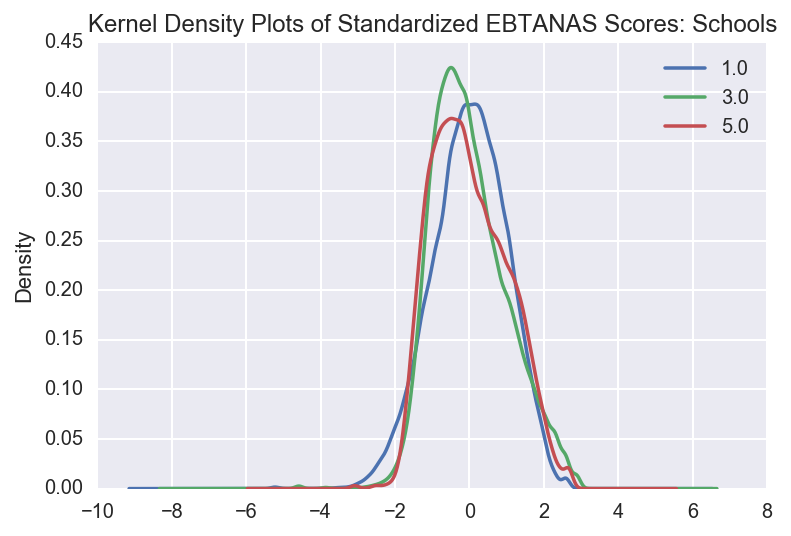

In [101]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
( Sch_Test_Scores
          .groupby(["School_Type"], as_index=False)
          ["IND Z_Score"]
          .plot(kind='density',
                title='Kernel Density Plots of Standardized EBTANAS Scores: Schools',
                legend=True) );